## Import Data 

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv(r"bloodpressurestudy.csv",index_col="subject")

In [15]:
df

,drug,before,after
subject,,,
1,Ramipril,194,157
2,Ramipril,162,136
3,Ramipril,183,145
4,Ramipril,180,153
5,Lisinopril,154,124
6,Lisinopril,184,123
7,Lisinopril,173,143
8,Lisinopril,170,136
9,Moexipril,158,124


## Exploratory Data Analysis

In [16]:
#Summary Statistics
df.describe()

,before,after
count,12.000000,12.000000
mean,174.250000,135.833333
std,12.512721,11.621558
min,154.000000,123.000000
25%,164.250000,124.000000
50%,176.500000,134.500000
75%,183.250000,143.500000
max,194.000000,157.000000


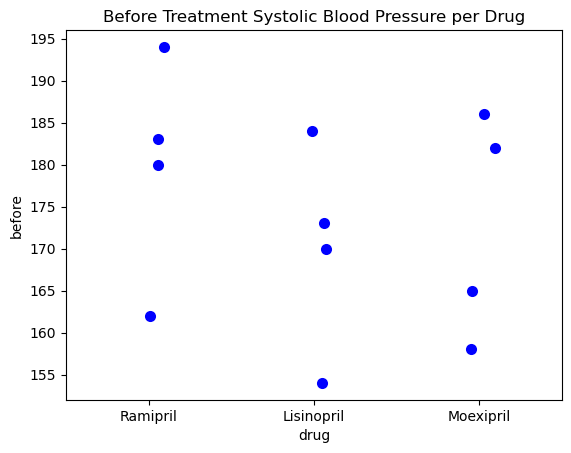

In [17]:
##Dot Plot

sns.stripplot(x="drug" , y="before" , data = df , color = "blue" , jitter = True , size = 8)
plt.title("Before Treatment Systolic Blood Pressure per Drug")
plt.show()

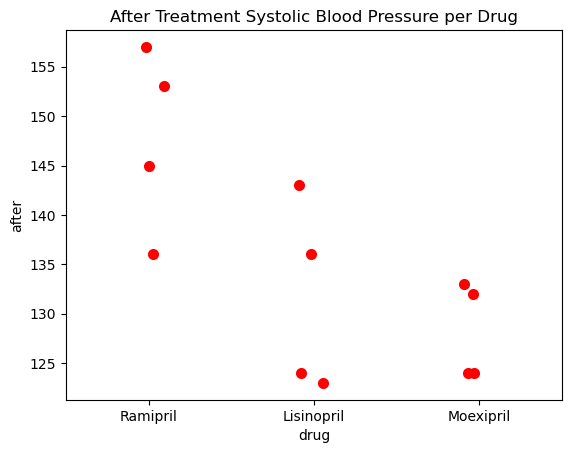

In [18]:
sns.stripplot(x="drug" , y="after" , data = df , jitter = True , color = "red" , size = 8)
plt.title("After Treatment Systolic Blood Pressure per Drug")
plt.show()

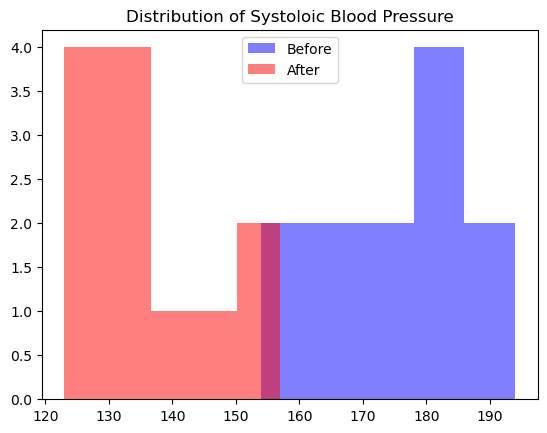

In [23]:
plt.hist(df["before"], bins = 5, alpha = 0.5 , label = "Before" ,  color = "blue" )
plt.hist(df["after"] ,  bins = 5, alpha = 0.5 , label = "After" , color = "red")
plt.legend()
plt.title("Distribution of Systoloic Blood Pressure")
plt.show()

In [28]:
df["difference"] = df["after"] - df["before"]
print(df.groupby("drug")["difference"].describe())

            count   mean        std   min    25%   50%    75%   max
drug                                                               
Lisinopril    4.0 -38.75  14.952703 -61.0 -40.75 -32.0 -30.00 -30.0
Moexipril     4.0 -44.50   8.812869 -54.0 -50.25 -45.0 -39.25 -34.0
Ramipril      4.0 -32.00   6.377042 -38.0 -37.25 -32.0 -26.75 -26.0


C:\Users\attafuro\AppData\Local\Temp\ipykernel_7616\1476474855.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(


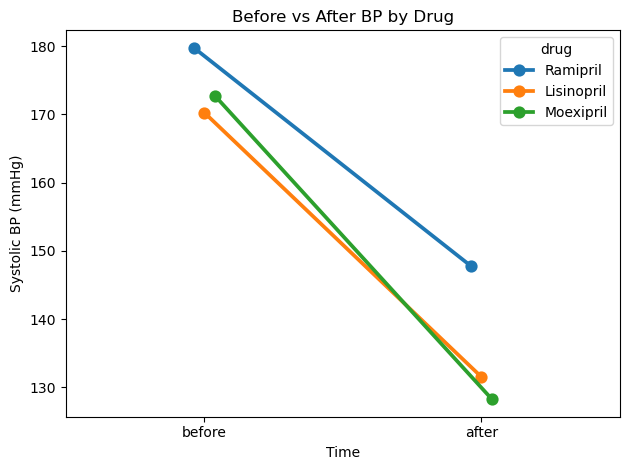

In [35]:
# If 'subject' is not a column (because it was used as index), bring it back
if "subject" not in df.columns:
    df = df.reset_index()  # this will restore the index as a column named by its index name (likely 'subject')

# Melt to long format for Before/After plotting
df_melted = df.melt(
    id_vars=["subject", "drug"],
    value_vars=["before", "after"],
    var_name="time",
    value_name="bp"
)

# Ensure the x-axis shows 'before' then 'after' in the right order
df_melted["time"] = pd.Categorical(df_melted["time"], categories=["before", "after"], ordered=True)

# Plot mean BP per drug, connected from before→after (classic interaction plot)
sns.pointplot(
    x="time", y="bp", hue="drug",
    data=df_melted,
    ci=None, markers="o", dodge=True, capsize=.1
)

plt.title("Before vs After BP by Drug")
plt.xlabel("Time")
plt.ylabel("Systolic BP (mmHg)")
plt.tight_layout()
plt.show()


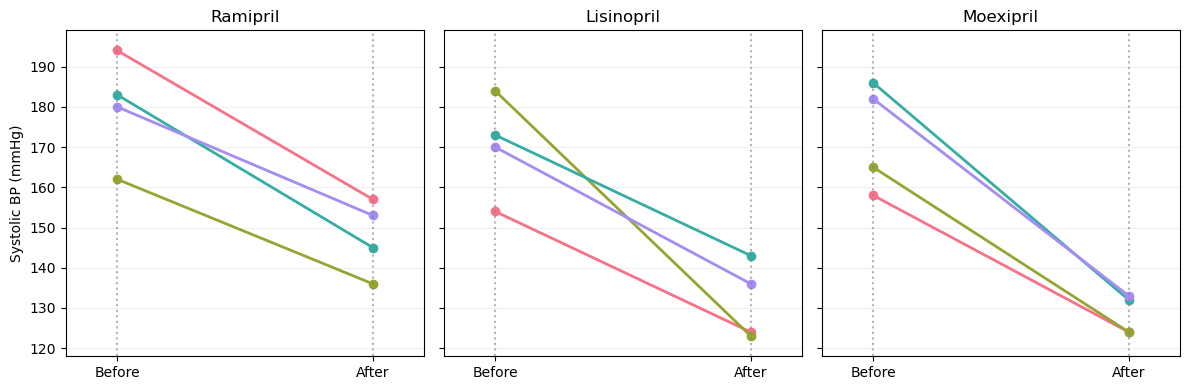

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- make sure 'subject' is a column ---
if "subject" not in df.columns:
    df = df.reset_index()

# order drugs (change if you prefer a different order)
drug_order = ["Ramipril", "Lisinopril", "Moexipril"]
drug_order = [d for d in drug_order if d in df["drug"].unique()]  # keep only those present

# x positions for before/after
x = np.array([0, 1])
xlabels = ["Before", "After"]

# y range shared across panels (with a little padding)
ymin = min(df["before"].min(), df["after"].min()) - 5
ymax = max(df["before"].max(), df["after"].max()) + 5

# figure + axes
fig, axes = plt.subplots(1, len(drug_order), figsize=(12, 4), sharey=True)

if len(drug_order) == 1:
    axes = [axes]  # ensure iterable

for ax, drug in zip(axes, drug_order):
    dsub = df[df["drug"] == drug].copy()

    # color per subject within each drug
    colors = sns.color_palette("husl", n_colors=len(dsub))

    for (idx, row), c in zip(dsub.iterrows(), colors):
        ax.plot(x, [row["before"], row["after"]],
                marker="o", lw=2, color=c)

    # cosmetics
    ax.set_title(drug)
    ax.set_xlim(-0.2, 1.2)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(ymin, ymax)

    # light vertical guides like in papers
    ax.axvline(0, ls=":", color="grey", alpha=0.6)
    ax.axvline(1, ls=":", color="grey", alpha=0.6)
    ax.grid(axis="y", alpha=0.2)

axes[0].set_ylabel("Systolic BP (mmHg)")
plt.tight_layout()
plt.show()


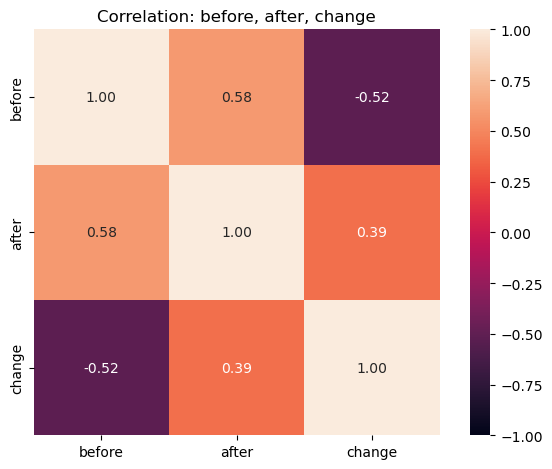

In [38]:
corr = df[["before", "after", "change"]].corr(method="pearson")
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True)
plt.title("Correlation: before, after, change")
plt.tight_layout()
plt.show()


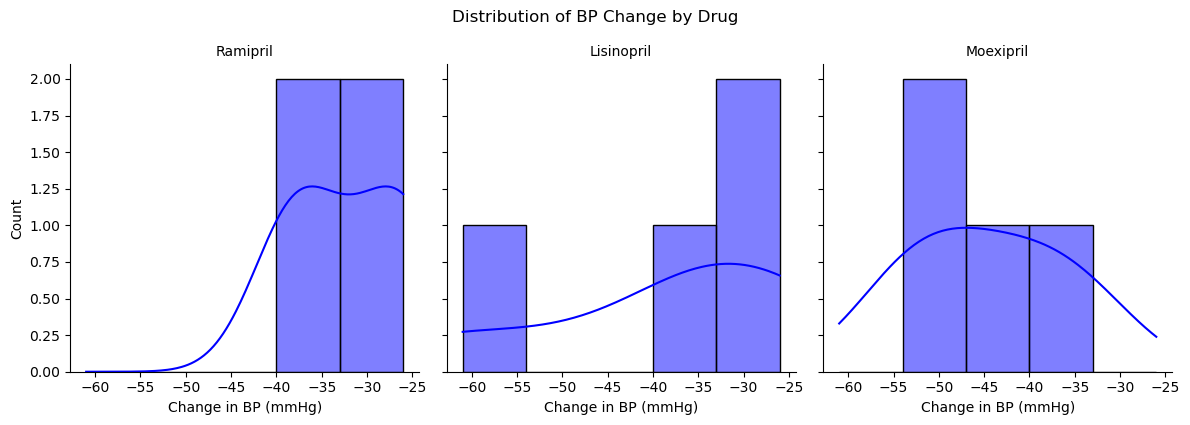

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure change column exists
df["change"] = df["after"] - df["before"]

# Faceted histograms of change per drug
g = sns.displot(
    data=df,
    x="change",
    col="drug",
    bins=5,
    kde=True,   # adds a smooth density curve overlay
    color="blue",
    height=4,
    aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Change in BP (mmHg)", "Count")
plt.suptitle("Distribution of BP Change by Drug", y=1.05)
plt.show()


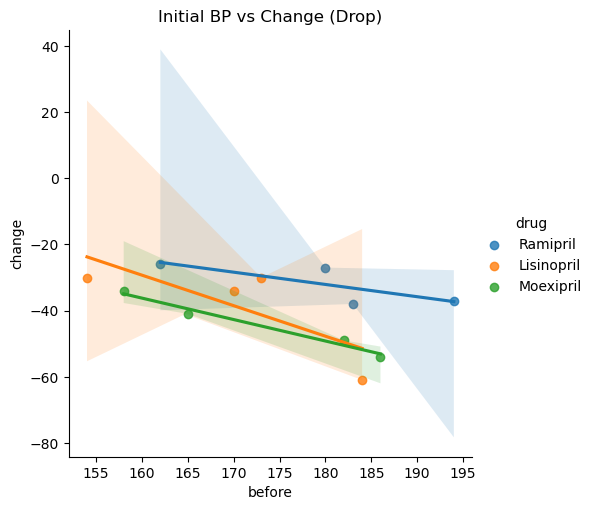

In [41]:
sns.lmplot(x="before", y="change", hue="drug", data=df, fit_reg=True)
plt.title("Initial BP vs Change (Drop)")
plt.show()
